<a href="https://colab.research.google.com/github/mchivuku/CSCI-B657-CV-Labs/blob/master/Computer_Vision_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab 3 - Harris Detection **

What to do
Write a Python program to do the following:
1. Given an input image, your program should rst convert it to grayscale.
2. Calculate the partial derivative of the image in the x and y directions. You can do this by convolving
the grayscale image with a lter that looks like

−1 1
for the x direction and

−1
1

for the y direction. Let us call the results of these convolutions Ix and Iy, respectively.
3. Let I
2
x = Ix × Ix
4. Let IxIy = Ix × Iy
5. Let I
2
y = Iy × Iy
6. Calculate AW , BW , CW by convolving I
2
x
, IxIy, I
2
y with a box lter, such as


1 1 1
1 1 1
1 1 1


7. Compute the eigenvalues of

AW BW
BW CW

at each pixel and only keep those where min(λ1, λ2) > T where T is some threshold.
8. Visually mark the detected corners from the previous step on top of the original image. Save the
output to a le.
9. Optional Apply non-maximal suppression on the results from the step 7 to avoid multiple detections

In [0]:
import numpy as np
import imageio
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt
import scipy.fftpack as F2

from matplotlib.colors import LogNorm

%matplotlib inline

plt.style.use("fivethirtyeight")


In [2]:
## Mount google drive

from google.colab import drive

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Masters-DS/Computer-Vision/labs/lab3
%ls

/content/drive/My Drive/Masters-DS/Computer-Vision/labs/lab3
image.png  lab_3.pdf


In [0]:
## functions
## Helper functions - read image, perform FFT
"""
Read image and convert to grayscale
"""
def read_image(file):
  image = Image.open(file).convert("L")
  return image

"""
Show image
"""
def show_image(image):
  plt.imshow(np.array(image).astype(np.uint8),cmap="gray")
  plt.axis('off')
  plt.show()
  

"""
Normalize
"""  
def normalize(vector):
  base = np.min(vector)
  roof = np.max(vector)
  diff = roof - base
  scale = diff/255
  vector = vector - base
  return vector//scale

compute_padding = lambda f: int ( (f - 1) / 2 )

"""
Convolution
"""
def convolve( image, filter ):
    m, n = filter.shape
    if m != n:
        raise Exception ( "Kernel is not symmetric" )
    else:
        h, w = image.shape
        h_new, w_new = h - m + 1, w - m + 1
        new_image = np.zeros ( shape=(h_new, w_new) )
        output = np.zeros ( shape=(h, w) )
        padding = compute_padding ( m )
        for i in range ( h_new ):
            for j in range ( w_new ):
                new_image[i, j] = np.sum ( image[i:i + m, j:j + m] * filter )

        output[padding:-padding, padding:-padding] = new_image
        return output

"""
Save image
"""
def save_image(imarray, filename):
  I_image = Image.fromarray(normalize(imarray))
  if I_image.mode != 'RGB':
    I_image = I_image.convert('RGB')
    
  I_image.save(filename)
  


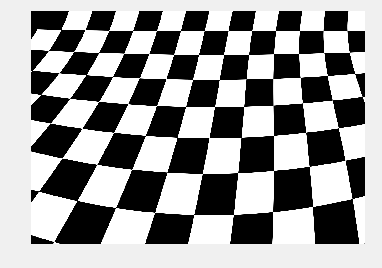

In [68]:
image = read_image("image.png")
show_image(image)

In [0]:
gradient_x = np.array([[0,0,0],[-1,1,0],[0,0,0]])
gradient_y = np.array([[0,-1,0],[0,1,0],[0,0,0]])
#gradient_x, gradient_y = np.gradient(image)


In [0]:

## convolution
image = np.array(image)
image_gradient_x = convolve(image,gradient_x)
image_gradient_y  = convolve(image, gradient_y)

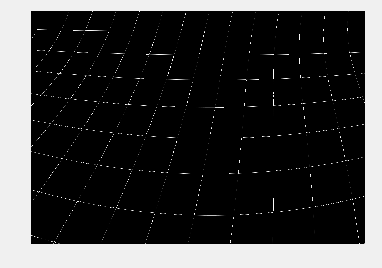

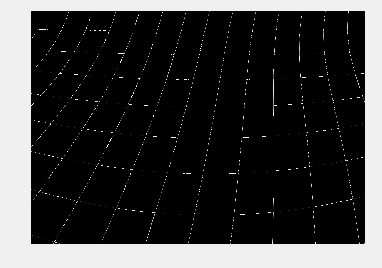

In [83]:

I_x = image_gradient_x
I_y = image_gradient_y

save_image(I_x,"I_x.png")
save_image(I_x,"I_y.png")

show_image(I_y)
show_image(I_x)




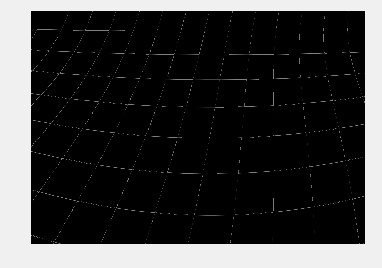

In [14]:
show_image(I_x)

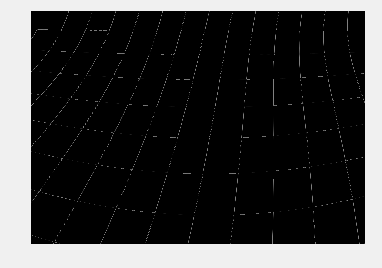

In [15]:
show_image(I_y)

In [0]:
I_x_sq = image_gradient_x **2
I_y_sq = image_gradient_y **2
I_xy = image_gradient_x * image_gradient_y

#I_x_sq = normalize(I_x_sq)
#I_y_sq = normalize(I_y_sq)
#I_xy = normalize(I_xy)

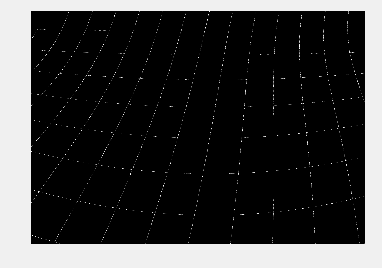

In [85]:
show_image(I_x_sq)
save_image(I_x_sq,"I_x_sq.png")

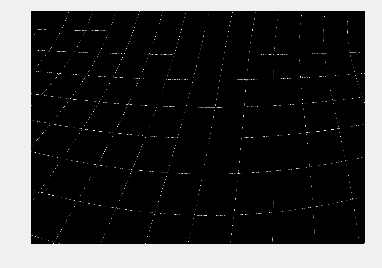

In [86]:
show_image(I_y_sq)
save_image(I_y_sq,"I_y_sq.png")

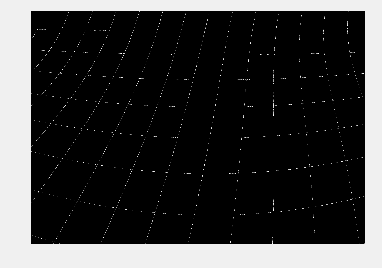

In [87]:
show_image(I_xy)
save_image(I_xy,"I_xy.png")

In [88]:
box_filter = np.ones(shape=(3,3))
box_filter

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [0]:
#AW, BW, CW by convolving I2x, IxIy, I2y with
A_w = convolve(I_x_sq,box_filter)


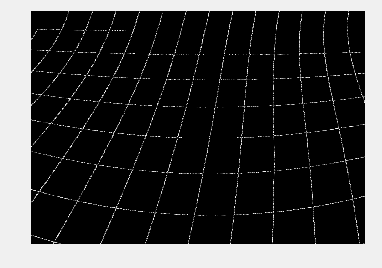

In [91]:
show_image(A_w)
save_image(A_w,"A_w.png")

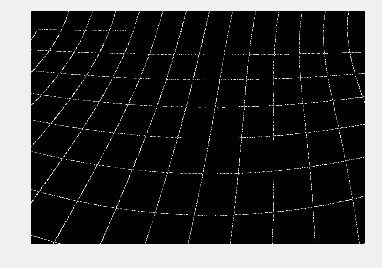

In [92]:
B_w = convolve(I_xy,box_filter)
show_image(B_w)
save_image(B_w,"B_w.png")

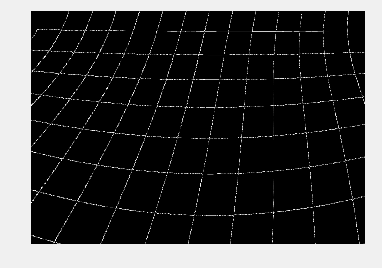

In [93]:
C_w = convolve(I_y_sq,box_filter)
show_image(C_w)
save_image(C_w,"C_w.png")

In [0]:
#Compute the eigenvalues of  AW BW BW CW , at each pixel and only keep those where min(λ1, λ2) > T where T is some threshold.
import cv2
  
"""
Compute eigen values
"""
def compute_eigen_values_vector(Aw,Bw,Cw,y,x):
  eigen_values , eig_vectors = np.linalg.eig(np.array([[Aw[y][x],Bw[y][x]],[Bw[y][x],Cw[y][x]]]))
  # extract top two eigen values
  eigen_values = eigen_values[::-1]
  two_eigen_values = eigen_values[:2]
  return min(two_eigen_values) ## get min eigen value




In [0]:
## Draw on detected corner:
h, w = image.shape
threshold = 10000
corner_list = []
coord = np.zeros(shape=image.shape)
for y in range(h):
  for x in range(w):
    e = compute_eigen_values_vector(A_w,B_w,C_w,y,x)
    if e> threshold:
      corner_list.append([y,x,e])
      coord[y,x] = e

      

## Non-maximal suppression

In [0]:
offset_x, offset_y = 5, 5
for y in range(0,h-offset_y+1):
  for x in range(0,w-offset_x+1):
    window = coord[y:y+offset_y,x:x+offset_x]
    if np.sum(window)==0:
      local_maximum  = 0
    else:
      local_maximum = np.amax(window) ## return maximum along the axis
      
    max_coordinate = np.argmax(window)
    ## zero all except for local maximum
    window[:] =0
    window.flat[max_coordinate] = local_maximum
    



In [114]:
coord

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
im = Image.open("image.png")
draw = ImageDraw.Draw(im)
def draw_lines(draw,y,x):
  left = (x-1,y)
  right = (x+1,y)
  top = (x,y-1)
  bottom = (x,y+1)
  ## Non-maximal supression
  ## check values in given radius
  draw.line([left, right], fill=(255,0,0), width=5)
  draw.line([top, bottom], fill=(255,0,0), width=5)
  
for y in range(h):
  for x in range(w):
    if coord[y,x]!=0:
      draw_lines(draw, y,x)
      

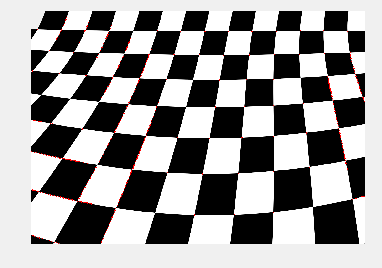

In [116]:
plt.imshow(im)
plt.axis('off')


im.save("final.png")